In [21]:
import argparse
import time
import numpy as np
from collections import defaultdict
from scipy import stats
import cv2

%matplotlib inline 
import matplotlib.pyplot as plt

In [77]:
def cartoonize(image):
    """
    convert image into cartoon-like image
    image: input PIL image
    """

    output = np.array(image)
    x, y, c = output.shape
    hists = []
    for i in range(c):
        output[:, :, i] = cv2.bilateralFilter(output[:, :, i], 5, 50, 50)
#         hist, _ = np.histogram(output[:, :, i], bins=np.arange(256+1))
#         hists.append(hist)
    edge = cv2.Canny(output, 100, 200)
    show_image(output)
    output = cv2.cvtColor(output, cv2.COLOR_RGB2HSV)

    #H
    hist, _ = np.histogram(output[:, :, 0], bins=np.arange(180+1))
    hists.append(hist)
    #S
    hist, _ = np.histogram(output[:, :, 1], bins=np.arange(256+1))
    hists.append(hist)
    #V
    hist, _ = np.histogram(output[:, :, 2], bins=np.arange(256+1))
    hists.append(hist)

    C = []
    for h in hists:
        C.append(k_histogram(h))
    print("centroids: {0}".format(C))
    show_image(output)
    output = output.reshape((-1, c))
    for i in range(c):
        channel = output[:, i]
        index = np.argmin(np.abs(channel[:, np.newaxis] - C[i]), axis=1)
        output[:, i] = C[i][index]
    output = output.reshape((x, y, c))
    show_image(output)
    output = cv2.cvtColor(output, cv2.COLOR_HSV2RGB)
    show_image(edge)
    contours, _ = cv2.findContours(edge,
                                   cv2.RETR_EXTERNAL,
                                   cv2.CHAIN_APPROX_NONE)
    # for i in range(len(contours)):
    #     tmp = contours[i]
    #     contours[i] = cv2.approxPolyDP(tmp, 2, False)
    show_image(cv2.drawContours(output, contours, -1, 0, thickness=1))
    return output


In [78]:
def update_C(C, hist):
    """
    update centroids until they don't change
    """
    while True:
        groups = defaultdict(list)
        #assign pixel values
        for i in range(len(hist)):
            if hist[i] == 0:
                continue
            d = np.abs(C-i)
            index = np.argmin(d)
            groups[index].append(i)

        new_C = np.array(C)
        for i, indice in groups.items():
            if np.sum(hist[indice]) == 0:
                continue
            new_C[i] = int(np.sum(indice*hist[indice])/np.sum(hist[indice]))
        if np.sum(new_C-C) == 0:
            break
        C = new_C
    return C, groups

In [79]:
def k_histogram(hist):
    """
    choose the best K for k-means and get the centroids
    """
    alpha = 0.001              # p-value threshold for normaltest
    N = 80                      # minimun group size for normaltest
    C = np.array([128])

    while True:
        C, groups = update_C(C, hist)

        #start increase K if possible
        new_C = set()     # use set to avoid same value when seperating centroid
        for i, indice in groups.items():
            #if there are not enough values in the group, do not seperate
            if len(indice) < N:
                new_C.add(C[i])
                continue

            # judge whether we should seperate the centroid
            # by testing if the values of the group is under a
            # normal distribution
            z, pval = stats.normaltest(hist[indice])
            if pval < alpha:
                #not a normal dist, seperate
                left = 0 if i == 0 else C[i-1]
                right = len(hist)-1 if i == len(C)-1 else C[i+1]
                delta = right-left
                if delta >= 3:
                    c1 = (C[i]+left)/2
                    c2 = (C[i]+right)/2
                    new_C.add(c1)
                    new_C.add(c2)
                else:
                    # though it is not a normal dist, we have no
                    # extra space to seperate
                    new_C.add(C[i])
            else:
                # normal dist, no need to seperate
                new_C.add(C[i])
        if len(new_C) == len(C):
            break
        else:
            C = np.array(sorted(new_C))
    return C

In [80]:
def show_image(img):
    cv2.imshow('Image' , img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [81]:
#Load Image
image = cv2.imread(r'input_img1.jpg')
show_image(image)

In [82]:
output = cartoonize(image)
show_image(output)

centroids: [array([ 19., 100., 125.]), array([102]), array([ 95., 142., 193.])]


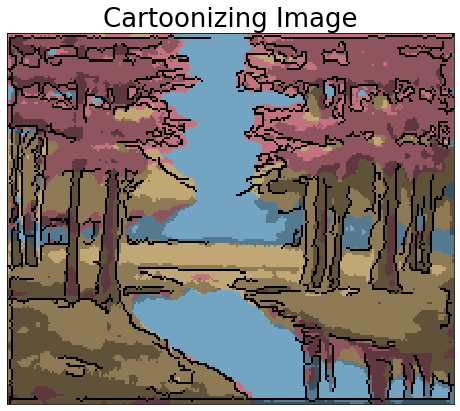

In [62]:
#Display output
plt.figure(num = 1, figsize=(8,8))
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.title('Cartoonizing Image', fontsize=26)
plt.gca().axes.get_yaxis().set_visible(False)
plt.gca().axes.get_xaxis().set_visible(False)
plt.show()